<a href="https://colab.research.google.com/github/viniciusrpb/cic0193_machinelearning/blob/main/cap9_1_basics_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 9

## Redes Neurais Convolucionais

Neste capítulo, introduziremos as **redes neurais convolucionais** (Convolutional Neural Networks - CNN), um tipo de rede neural artificial feedforward que incorpora camadas de entrada, ocultas e de saída. O diferencial das CNNs é a existência de camadas de convolução, geralmente incluídas nas camadas iniciais das arquiteturas. Assim, a presença dessas camadas permitem que os dados originais (*raw data*), como imagens e textos, sejam incluídos diretamente na camada de entrada, não necessitando de uma etapa explícita para extração de características, em que os vetores de características são obtidos.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,GlobalMaxPool2D,Activation,Conv2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt

Carregando o conjunto de dados de folhas que utilizaremos como exemplo:

In [ ]:
!cp -r "/content/drive/My Drive/leafs" "leafs"

### 9.1. Princípios de convolução de imagens

A convolução de um filtro *kernel* $w: \mathbb{R}^2 \rightarrow \mathbb{R}^p$ com uma imagem digital $I: \mathbb{R}^2 \rightarrow \mathbb{R}^p$ (input image), em que $p$ é a quantidade de canais de cores (profundidade) de $I$, é dada por:

\begin{align}
g(x,y)= w * I(x,y)= \sum_{i=-a}^a \sum_{j=-b}^b w(i,j) I(x+i,y+j)
\end{align}

em que $g(x,y)$ é a imagem de saída (output image). O filtro $w$ possui dimensões $(2a+1) \times (2b+1)$, em que $w(i,j)$ denota um coeficiente, para $-a \leq i \leq a$ e $-b \leq j \leq b$. 


Podemos definir diferentes filtros bastando ajustar apropriadamente seus coeficientes. Por exemplo, considere um filtro Laplaciano a seguir para detecção de bordas:


In [ ]:
w_laplace = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="float")

w_laplace

array([[ 0.,  1.,  0.],
       [ 1., -4.,  1.],
       [ 0.,  1.,  0.]])

Para realizar a operação de convolução da imagem original $I$ com o filtro de Laplace *w_laplace*, devemos percorrer $I$ pixel a pixel

Podemos implementar a operação de convolução como se segue:


In [ ]:
def convolution2D(I,w):

  (a,b) = w.shape
  (n,m) = I.shape

  pad_x = (a-1)//2
  pad_y = (b-1)//2

  output = np.zeros((n-2*pad_x,m-2*pad_y),dtype=float);

  for x in range(pad_x,n-pad_x):
    for y in range(pad_y,m-pad_y):

      s = 0

      for i in range(-pad_x,pad_x+1):
        for j in range(-pad_y,pad_y+1):
      
          s=s+w[i+pad_x,j+pad_y]*I[x+i,y+j]
      
      output[x - pad_x,y - pad_y] = s

  output = 255.*(output-output.min())/(output.max()-output.min())

  return output.astype(np.int32)

In [ ]:
img = cv2.imread("cicunb.png")

# guarantees the input image to be grayscale:
gray = np.array(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

g = convolution2D(gray,w_laplace)

As imagens a seguir apresentam a imagem original e a imagem de saída após o processo de convolução com o filtro Laplaciano:

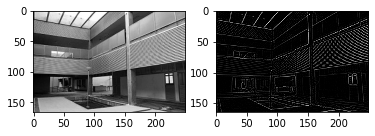

In [ ]:
_, axarr = plt.subplots(1,2)

axarr[0].imshow(gray,cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(g,cmap='gray', vmin=0, vmax=255)

In [ ]:
A seguir, um exemplo de convolução para suavizar uma imagem. Para tal, utiliza-se um filtro Gaussiano:


In [ ]:
w_gauss = np.array((
	[0,0, 1, 0,0],
  [0,2, 2, 2,0],
	[1,2, 5, 2,1],
	[0,2, 2, 2,0],
  [0,0, 1, 0,0]), dtype="float")

w_gauss

array([[0., 0., 1., 0., 0.],
       [0., 2., 2., 2., 0.],
       [1., 2., 5., 2., 1.],
       [0., 2., 2., 2., 0.],
       [0., 0., 1., 0., 0.]])

Pode-se perceber como a imagem foi "borrada", em que informações de bordas e regiões de mudanças de intensidade foram perdidas.

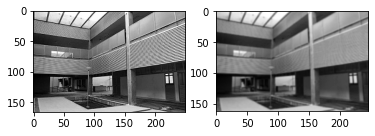

In [ ]:
g = convolution2D(gray,w_gauss)

_, axarr = plt.subplots(1,2)

axarr[0].imshow(gray,cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(g,cmap='gray', vmin=0, vmax=255)

## 

##Jargões

- Stride: pulo da evolução no processo de convolução entre uma imagem e um fitlro. O ideal é utilizarmos stride 1 ou 2 (caso a imagem seja grande). No stride 1, cada pixel da imagem é considerado na convolução, enquanto que no stride 2, o filtro é passado sobre a imagem a cada 2 pixels.

   Stride horizontal
   Stride vertical




In [ ]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_set = datagen.flow_from_directory('leafs',
                                        batch_size=32,
                                        class_mode='categorical',
                                        target_size=(64,64),
                                        subset='training')

validation_set = datagen.flow_from_directory('leafs',
                                        batch_size=32,
                                        class_mode='categorical',
                                        target_size=(64,64),
                                        subset='validation')

# test_set vou ficar devendo

In [ ]:
number_filters = 5
kernel_dimensions = (5,5)
tam_strides = (1,1)
number_of_neurons = 10
num_classes = 4

depth = 3

In [ ]:
model = Sequential()

model.add(Conv2D(filters=number_filters,kernel_size=kernel_dimensions,strides=tam_strides, padding='same',kernel_initializer='glorot_normal',activation='relu',input_shape=(64,64,depth)))

model.add(GlobalMaxPool2D())
# fullly connected faz o stretch do activation map 2d para um vetor
model.add(Dense(number_of_neurons))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [ ]:
model.summary()

In [ ]:
sgd = SGD(learning_rate=0.1)

model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [ ]:
model.fit(train_set,validation_data=validation_set,epochs=10)